In [1]:
# import igraph as ig
import networkx as nx

import matplotlib.pyplot as plt
import yaml

In [2]:
dag = []
with open("./dags/dytas_test_dag.yaml") as stream:
    try:
        dag = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

In [3]:
dag

{'inputs': [{'name': 'T0-input', 'size': 0}],
 'tasks': [{'name': 'T0',
   'flops': 10,
   'memory': 1000,
   'inputs': ['T0-input'],
   'outputs': [{'name': 'T0-output', 'size': 0}]},
  {'name': 'T1',
   'flops': 2,
   'memory': 1000,
   'inputs': ['T0-output'],
   'outputs': [{'name': 'T1-output', 'size': 8}]},
  {'name': 'T2',
   'flops': 10,
   'memory': 1000,
   'inputs': ['T0-output'],
   'outputs': [{'name': 'T2-output', 'size': 8}]},
  {'name': 'T3',
   'flops': 17,
   'memory': 1000,
   'inputs': ['T0-output'],
   'outputs': [{'name': 'T3-output', 'size': 5}]},
  {'name': 'T4',
   'flops': 4,
   'memory': 1000,
   'inputs': ['T3-output'],
   'outputs': [{'name': 'T4-output', 'size': 1}]},
  {'name': 'T5',
   'flops': 17,
   'memory': 1000,
   'inputs': ['T1-output'],
   'outputs': [{'name': 'T5-output', 'size': 9}]},
  {'name': 'T6',
   'flops': 2,
   'memory': 1000,
   'inputs': ['T0-output'],
   'outputs': [{'name': 'T6-output', 'size': 1}]},
  {'name': 'T7',
   'flops': 15,

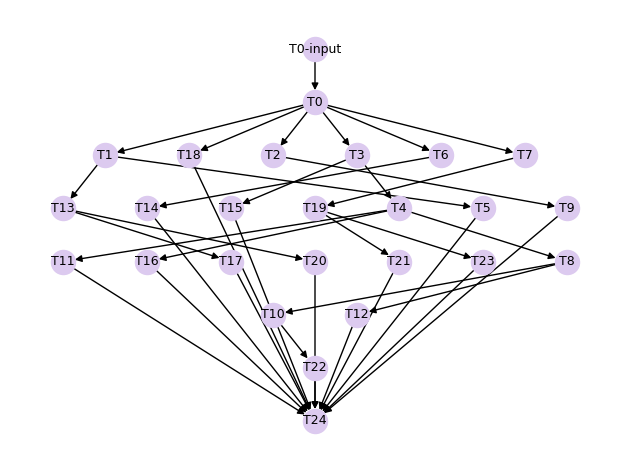

In [14]:
import networkx as nx, matplotlib.pyplot as plt

# ------------ Build G from scratch ------------
G = nx.DiGraph()

# for inp in dag['inputs']:
#     G.add_node(inp['name'], kind='input', flops=0)

out_task, out_size = {}, {}
for t in dag['tasks']:
    G.add_node(t['name'], kind='task', flops=t['flops'])
    for o in t['outputs']:
        out_task[o['name']] = t['name']
        out_size[(t['name'], o['name'])] = o['size']

for t in dag['tasks']:
    for obj in t['inputs']:
        src = out_task.get(obj, obj)     # obj is either another output or a raw input
        size = out_size.get((src, obj), 0)
        G.add_edge(src, t['name'], size=size)

# ------------ Layout (levelled) ------------
depth = {n: 0 for n in G}
for n in nx.topological_sort(G):
    for succ in G.successors(n):
        depth[succ] = max(depth[succ], depth[n] + 1)

pos = {}
for lvl, nodes in nx.utils.groups(depth).items():
    nodes = list(nodes)
    nodes.sort()
    w = len(nodes) - 1
    for i, n in enumerate(nodes):
        pos[n] = (i - w / 2, -lvl)

# ------------ Draw ------------
# task_nodes  = [n for n, d in G.nodes(data=True) if d['kind'] == 'task']
# input_nodes = [n for n, d in G.nodes(data=True) if d['kind'] == 'input']
# flops       = nx.get_node_attributes(G, 'flops')

nx.draw_networkx_nodes(G, pos, node_color="#DCCAEF")
nx.draw_networkx_edges(G, pos)
                
nx.draw_networkx_labels(G, pos, font_size=9)
plt.axis('off'); plt.tight_layout(); plt.show()


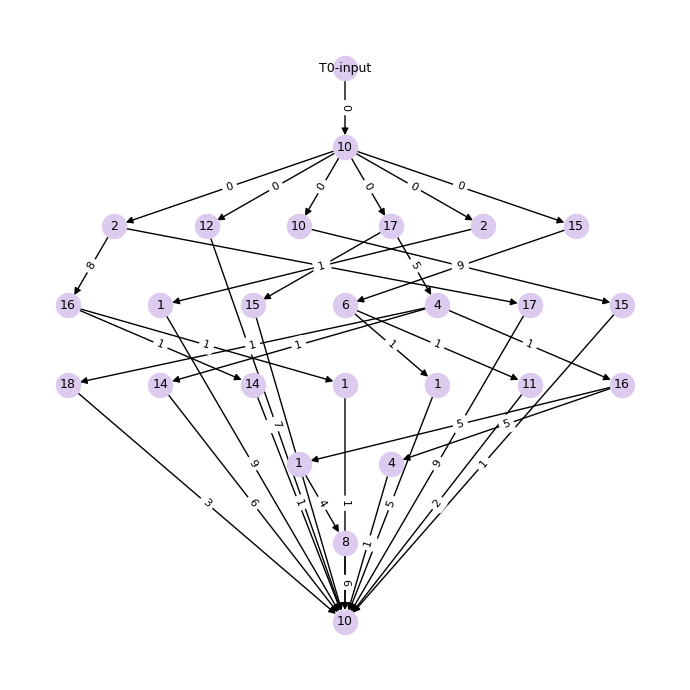

In [29]:
import networkx as nx, matplotlib.pyplot as plt

# ------------ Build G exactly as you already do ------------
G = nx.DiGraph()
out_task, out_size = {}, {}
for t in dag['tasks']:
    G.add_node(t['name'], kind='task', flops=t['flops'])
    for o in t['outputs']:
        out_task[o['name']] = t['name']
        out_size[(t['name'], o['name'])] = o['size']

for t in dag['tasks']:
    for obj in t['inputs']:
        src  = out_task.get(obj, obj)
        size = out_size.get((src, obj), 0)
        G.add_edge(src, t['name'], size=size)

# ------------ Layout (levelled) ------------
depth = {n: 0 for n in G}
for n in nx.topological_sort(G):
    for succ in G.successors(n):
        depth[succ] = max(depth[succ], depth[n] + 1)

pos = {}
for lvl, nodeset in nx.utils.groups(depth).items():
    nodes = sorted(nodeset)          # list → sortable
    w = len(nodes) - 1
    for i, n in enumerate(nodes):
        pos[n] = (i - w/2, -lvl)

# ------------ Draw with labels ------------
plt.figure(figsize=(7, 7))

# node colour, size, etc. (your original settings)
nx.draw_networkx_nodes(G, pos, node_color="#DCCAEF")
nx.draw_networkx_edges(G, pos)

# --- node labels: flops ---
flop_labels = {n: G.nodes[n].get('flops', n) for n in G.nodes()}
nx.draw_networkx_labels(G, pos, labels=flop_labels, font_size=9)

# --- edge labels: size ---
edge_labels = nx.get_edge_attributes(G, 'size')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

plt.axis('off')
plt.tight_layout()
plt.show()
